In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from pathlib import Path

In [2]:
folder_path = Path("mushra_csv/")
raw_data = []
for csv_path in folder_path.glob("*.csv"):
    data = pd.read_csv(csv_path)
    data = data[~data["trial_id"].str.contains("train_")]
    data = data.pivot_table(
        index=["session_uuid", "trial_id", "age", "gender", "equipment", "experience", "rating_time"],
        columns=["rating_stimulus"],
        values="rating_score",
    ).reset_index()
    raw_data.append(data)

# remove first column
concat_data = pd.concat(raw_data, ignore_index=True)

session_uuid
6e9a3f6b-648c-4f19-b520-bb11b4835a2c    0.000000
a021b844-43c7-4476-8f39-40d6c5009bca    0.000000
c934903d-8d0c-4ea3-bcb9-c9f43d71984b    0.000000
476ee55f-71f0-4dd0-9073-b882d06ef26a    0.222222
6243f93d-53be-4b58-b59a-fb0d066e06d1    0.222222
cd20989f-99ae-4b0c-b889-3cf3d4e7f1b5    0.333333
4b9e0e24-9292-4051-928a-ca3f9c154988    0.333333
aa893d0c-2412-4397-a846-3ed539bb89a5    0.333333
eed7128a-82b5-482a-96ef-69050d95b7db    0.500000
dee01af6-3c32-4cc6-aab7-503e5ff1d24c    0.555556
bc008c93-4c90-4a88-b9a6-294fbeb31b66    0.600000
869a8e04-a35d-4753-ad7d-3ba179cf63ab    0.600000
82f6c4d0-dca0-4b4b-8c7d-0542b5ea7c7f    0.600000
daa2618d-db0a-4f59-975c-6a2b721f9364    0.666667
77d7df2d-f500-4577-b55a-f41884286a85    0.700000
ba58bd63-8e31-4071-89ed-e7749ccf08c8    0.777778
57cc1081-fe41-4f05-b6c2-33e4c3c0b19c    0.800000
f53c0288-d02e-427b-8150-1e90536481db    0.888889
dda05b96-8d4f-4695-a815-3a1e8b228e3a    0.888889
a72801fe-9533-44eb-97c1-dcdcad722e1e    0.900000
0382789

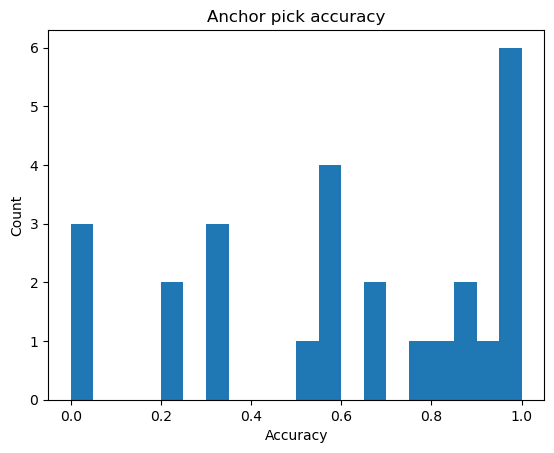

Drop 8 UUIDs with anchor pick accuracy < 0.4
Remaining 18 subjects


In [3]:
raw_rationgs = concat_data.loc[:, ["session_uuid", "afx_01", "anchor", "gt", "mfcc_1", "nn_mfcc", "regression"]]
# raw_questions = concat_data.loc[:, ["session_uuid"]]

pick_anchor_acc = raw_rationgs.groupby("session_uuid").agg(lambda x: np.count_nonzero(x < 20) / len(x))
print(pick_anchor_acc["anchor"].sort_values())
plt.hist(pick_anchor_acc["anchor"], bins=20)
plt.title("Anchor pick accuracy")
plt.xlabel("Accuracy")
plt.ylabel("Count")
plt.show()

threshold = 0.4
drop_uuid = pick_anchor_acc[pick_anchor_acc["anchor"] < threshold].index
# print(drop_uuid)
filtered_data = concat_data[~concat_data["session_uuid"].isin(drop_uuid)]
print(f"Drop {len(drop_uuid)} UUIDs with anchor pick accuracy < {threshold}")
print(f"Remaining {len(pick_anchor_acc) - len(drop_uuid)} subjects")

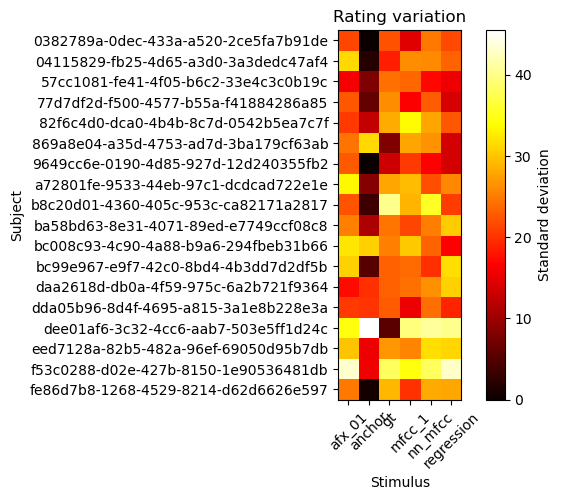

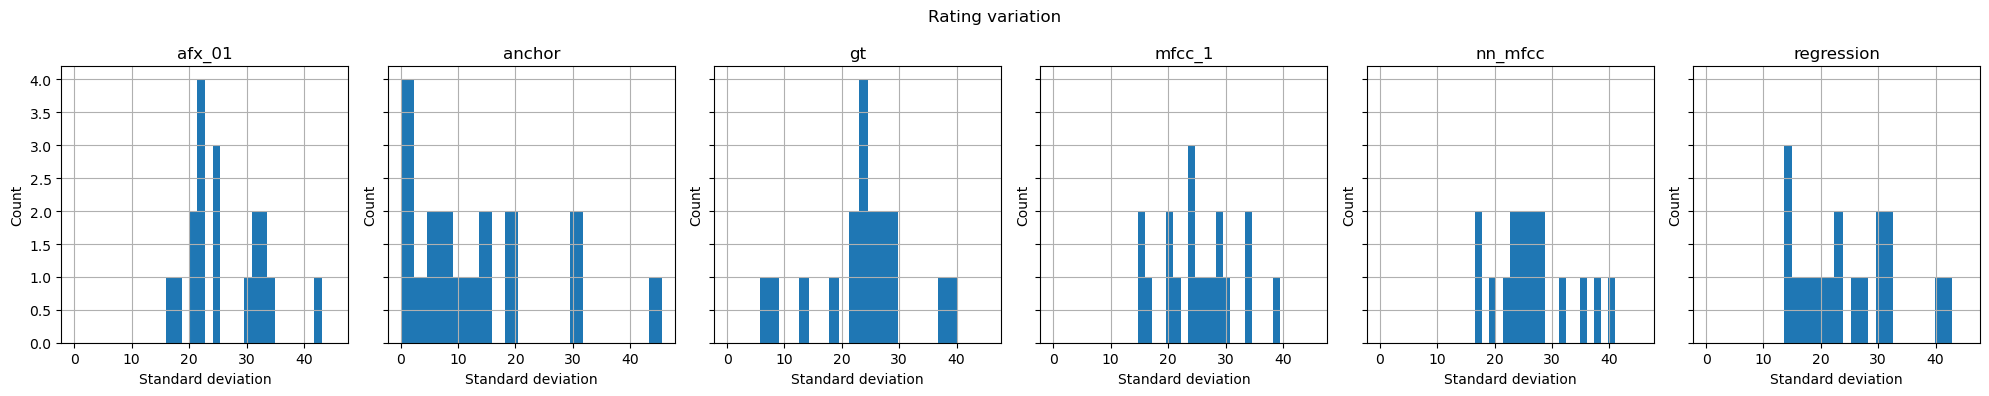

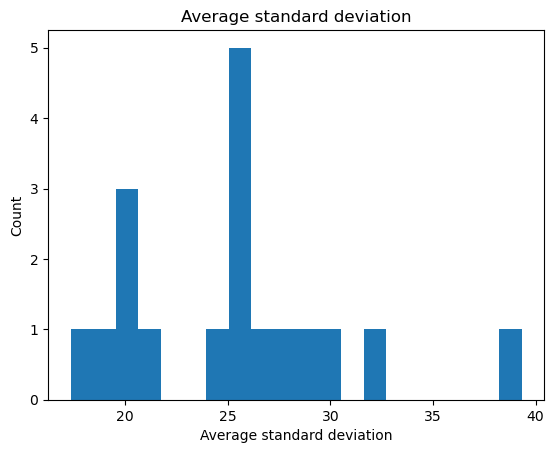

Drop 2 UUIDs with std > 30
Remaining 16 subjects


In [4]:
# analysis rating variation
rating_variation = filtered_data.loc[
    :, ["session_uuid", "afx_01", "anchor", "gt", "mfcc_1", "nn_mfcc", "regression"]
]
rating_variation = rating_variation.groupby(["session_uuid"]).std()

# drop subject has variations very different from others
plt.imshow(rating_variation.to_numpy(), cmap="hot", interpolation="nearest")
plt.title("Rating variation")
plt.xlabel("Stimulus")
plt.ylabel("Subject")
plt.xticks(
    ticks=range(len(rating_variation.columns)),
    labels=rating_variation.columns,
    rotation=45,
)
plt.yticks(ticks=range(len(rating_variation.index)), labels=rating_variation.index)
plt.colorbar(label="Standard deviation")
plt.show()

fig, ax = plt.subplots(1, 6, figsize=(20, 4), sharex=True, sharey=True)
for i, col in enumerate(rating_variation.columns):
    ax[i].set_title(col)
    ax[i].hist(rating_variation[col], bins=20)
    ax[i].set_xlabel("Standard deviation")
    ax[i].set_ylabel("Count")
    ax[i].grid()
plt.suptitle("Rating variation")
plt.tight_layout()
plt.show()

avg_std = rating_variation.drop(columns=["anchor"]).mean(axis=1)
plt.hist(avg_std, bins=20)
plt.title("Average standard deviation")
plt.xlabel("Average standard deviation")
plt.ylabel("Count")
plt.show()

# drop subject with anchor std > 40
drop_uuid = rating_variation[(rating_variation["anchor"] > 40) | (avg_std > 30)].index
filtered_data2 = filtered_data[~filtered_data["session_uuid"].isin(drop_uuid)]
print(f"Drop {len(drop_uuid)} UUIDs with std > 30")
print(f"Remaining {len(rating_variation) - len(drop_uuid)} subjects")

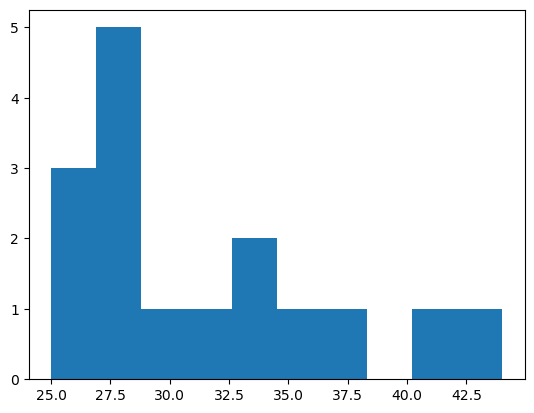

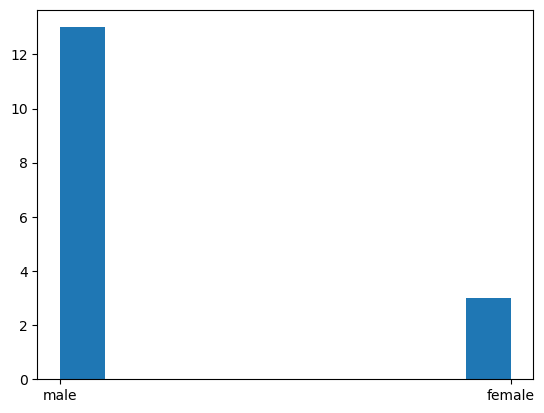

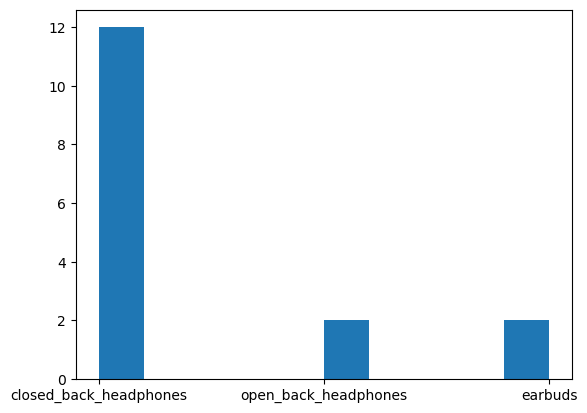

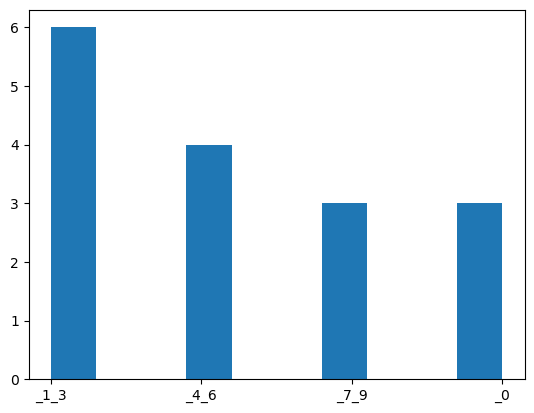

In [5]:
ages = [filtered_data2.groupby("session_uuid")["age"].first().values]
genders = [filtered_data2.groupby("session_uuid")["gender"].first().values]
equipments = [filtered_data2.groupby("session_uuid")["equipment"].first().values]
experiences = [filtered_data2.groupby("session_uuid")["experience"].first().values]


plt.hist(ages)
plt.show()

plt.hist(genders)
plt.show()

plt.hist(equipments)
plt.show()

plt.hist(experiences)
plt.show()

(16, 6)
['afx_01', 'anchor', 'gt', 'mfcc_1', 'nn_mfcc', 'regression'] [1 5 3 4 0 2]


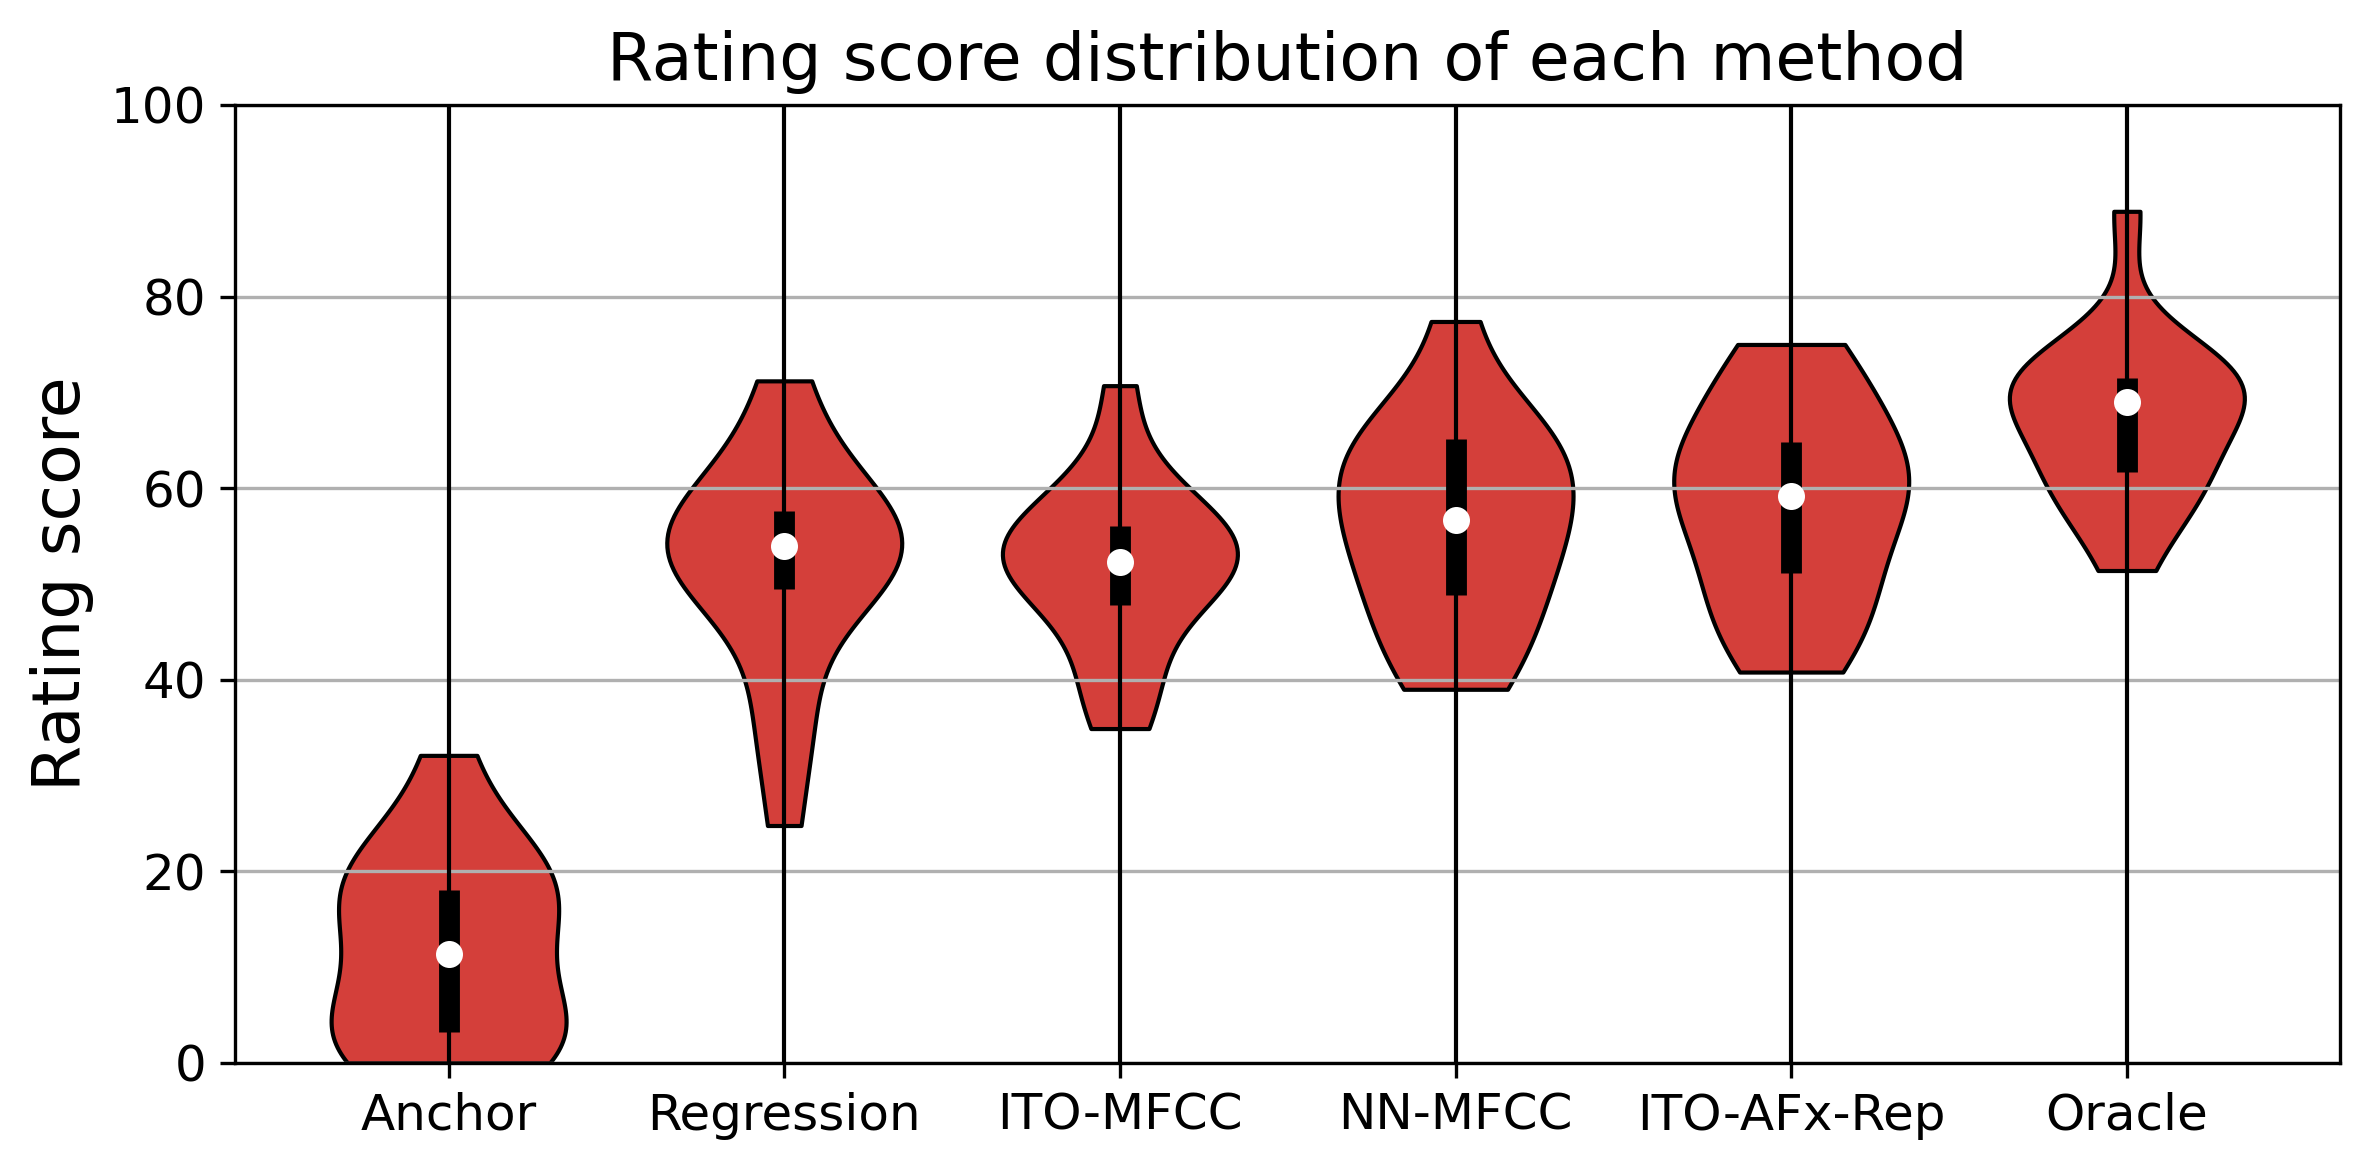

In [6]:
ratings = filtered_data2.loc[:, ["session_uuid", "afx_01", "anchor", "gt", "mfcc_1", "nn_mfcc", "regression"]]
avg_data = ratings.groupby(["session_uuid"]).mean()
print(avg_data.shape)

mean_ratings = avg_data.values.T

order = np.argsort(mean_ratings.mean(1))
mean_ratings = mean_ratings[order]
keys = avg_data.columns.tolist()
print(keys, order)
keys = [keys[i] for i in order]
# ratings = [data["rating_score"].values for _, data in grouped]

fig = plt.figure(figsize=(8, 4), dpi=300)
parts = plt.violinplot(
    mean_ratings.tolist(),
    vert=True,
    widths=0.7,
    # quantiles=[[0.25, 0.5, 0.75]] * len(grouped),
    # showmeans=True,
    showextrema=False,
    # showmedians=True,
)
for pc in parts["bodies"]:
    pc.set_facecolor("#D43F3A")
    pc.set_edgecolor("black")
    pc.set_alpha(1)
convert_dict = {
    "anchor": "Anchor",
    "gt": "Oracle",
    "regression": "Regression",
    "nn_mfcc": "NN-MFCC",
    "mfcc_1": "ITO-MFCC",
    "afx_01": "ITO-AFx-Rep",
}
quartile1, medians, quartile3 = np.percentile(mean_ratings, [25, 50, 75], axis=1)
inds = np.arange(1, len(medians) + 1)
plt.scatter(inds, medians, marker="o", color="white", s=30, zorder=3)
plt.vlines(inds, quartile1, quartile3, color="k", linestyle="-", lw=5)
plt.vlines(inds, 0, 100, color="k", linestyle="-", lw=1)
plt.xticks(
    range(1, 7), [convert_dict[k] for k in keys], rotation=0
)
plt.ylabel("Rating score", fontdict={"fontsize": 16})
plt.title("Rating score distribution of each method", fontdict={"fontsize": 16})
plt.tick_params(axis="x", labelsize=12)
plt.tick_params(axis="y", labelsize=12)
plt.tight_layout()
plt.ylim(0, 100)
plt.grid(axis="y")
plt.show()

In [7]:
# compute wilcoxon signed-rank test
# for each pair of stimuli
stimuli = keys
print(stimuli)
p_values = []
for i, stimulus1 in enumerate(stimuli):
    for j, stimulus2 in enumerate(stimuli):
        if i >= j:
            continue
        _, p_value = stats.wilcoxon(avg_data[stimulus1], avg_data[stimulus2])
        p_values.append((stimulus1, stimulus2, p_value))


# sort the p-values
p_values.sort(key=lambda x: x[2])
# print the p-values
for stimulus1, stimulus2, p_value in p_values:
    if p_value >= 0.01:
        print(f"{stimulus1} vs {stimulus2}: p = {p_value:.3f}")

['anchor', 'regression', 'mfcc_1', 'nn_mfcc', 'afx_01', 'gt']
afx_01 vs gt: p = 0.023
mfcc_1 vs afx_01: p = 0.030
regression vs afx_01: p = 0.117
mfcc_1 vs nn_mfcc: p = 0.231
regression vs nn_mfcc: p = 0.274
nn_mfcc vs afx_01: p = 0.495
regression vs mfcc_1: p = 0.660
